## Введение

**Промышленность — задача проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<div class="alert alert-block alert-info">
План:
    
1. Проверить каждый датасет на дубликаты, пропуски, типы данных
    
2. Понять имеются ли аномалии в данных и решить, что с ними делать
</div>

## Загрузка данных

In [1]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import missingno as msno
from IPython.display import display
sns.set_style("darkgrid")
import scipy.stats as sps
import math
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
import time
import itertools
import urllib.request
from scipy import stats
from pathlib import Path
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df_arc=pd.read_csv('/datasets/final_steel/data_arc.csv')
df_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


In [6]:
df_bulk=pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [7]:
df_gas=pd.read_csv('/datasets/final_steel/data_gas.csv')
df_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [8]:
df_temp=pd.read_csv('/datasets/final_steel/data_temp.csv')
df_temp.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [9]:
df_wire=pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
Данные загружены, но не все
    
Нет смысла загружать данные bulk_time и wire_time, потому что использовать в дальнейшей работе мы не будем.

Можно проводить предобработку данных
</div>

## Предобработка данных

### Данные об электродах

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9491,2059,2019-07-21 19:50:16,2019-07-21 19:52:10,0.393992,0.238762
8654,1883,2019-07-09 09:40:20,2019-07-09 09:41:58,0.325188,0.255067
5244,1138,2019-06-13 20:21:19,2019-06-13 20:23:30,0.561328,0.399679


-------------------------------------------------------------------------------------------------------------
**Вывод первых пяти строк датафрейма**


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


0

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
-------------------------------------------------------------------------------------------------------------
None


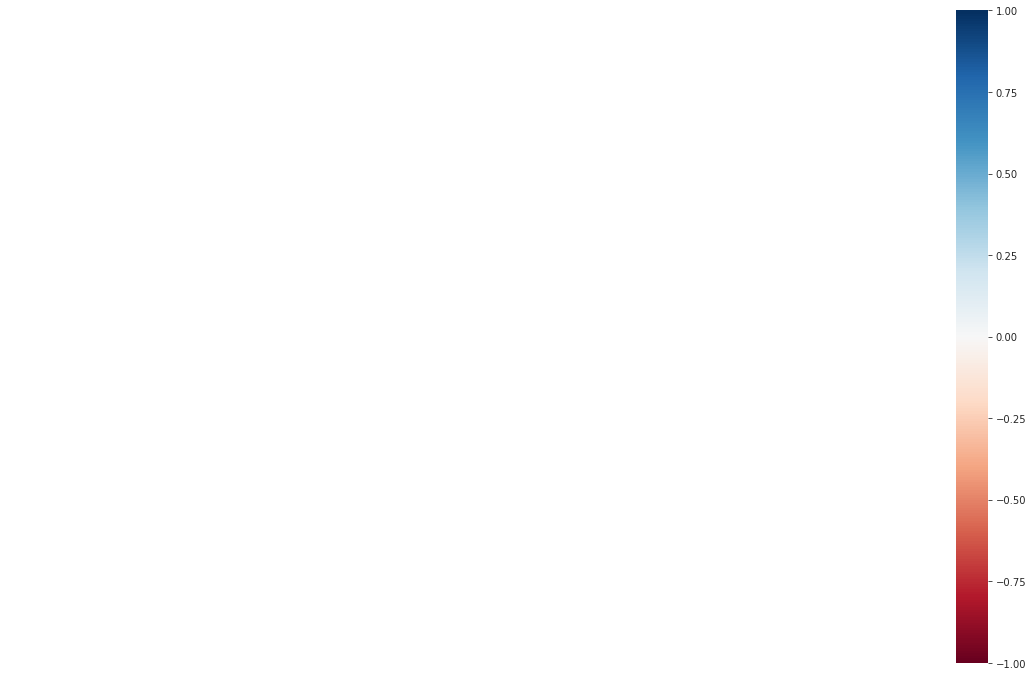

In [10]:
def fun_date(data):
    print('**Общая информация датафрейма**')
    display(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Просмотр статистических данных**')
    display(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод рандомных строк датафрейма**')
    display(data.sample(n=3, random_state=1))
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод первых пяти строк датафрейма**')
    display(data.head())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва дубликатов датафрейма**')
    display(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва пропущеных значений датафрейма**')
    display(data.isnull().sum())
    print(msno.heatmap(data))
    print('-------------------------------------------------------------------------------------------------------------')
print(fun_date(df_arc))

In [11]:
#Приведем данные к нужному виду
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [12]:
#Взглянем на количество занимаемой памяти более детально
def memory(data):
    for dtype in ['float','int','object']:
        selected_dtype = data.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))
print(memory(df_arc))

Average memory usage for float columns: 0.08 MB
Average memory usage for int columns: 0.06 MB
Average memory usage for object columns: 0.00 MB
None


In [13]:
#Посмотрим количество уникальных значений номера партии
len((df_arc['key']).unique())

3214

Text(0.5, 1, 'График зависимости номера партии от итерации обработки')

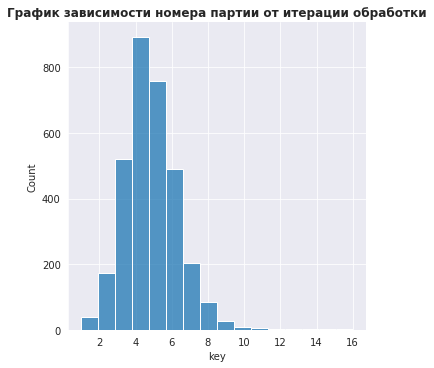

In [14]:
fig = sns.displot(df_arc['key'].value_counts(),bins=16)
plt.title('График зависимости номера партии от итерации обработки', fontweight='bold')

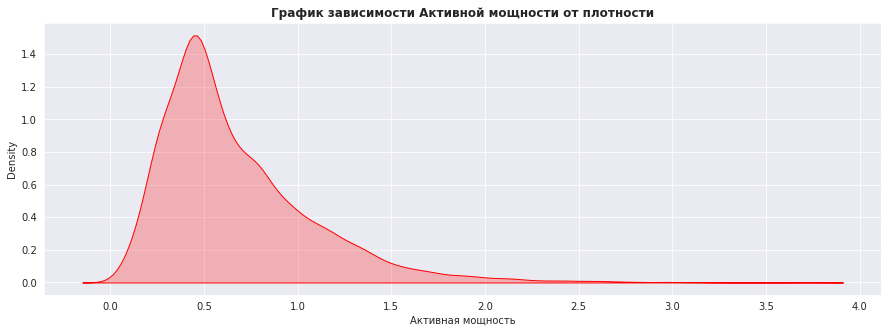

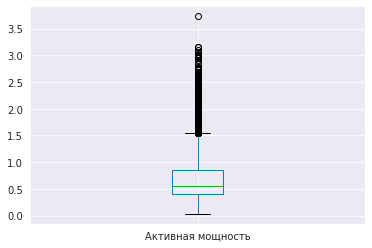

In [15]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Активная мощность'],color='r', legend=True,shade=True)
plt.title('График зависимости Активной мощности от плотности', fontweight='bold')
plt.show()
fig2 =df_arc.boxplot('Активная мощность')

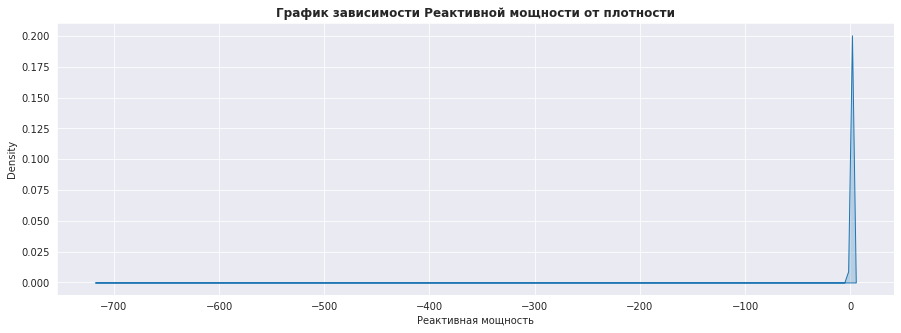

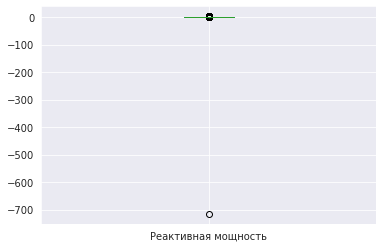

In [16]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'], legend=True,shade=True)
plt.title('График зависимости Реактивной мощности от плотности', fontweight='bold')
plt.show()
fig2 =df_arc.boxplot('Реактивная мощность')

Имеются аномалии в данных, от них лучше избавимся

In [17]:
df_arc =df_arc[df_arc['Реактивная мощность'] >= 0]

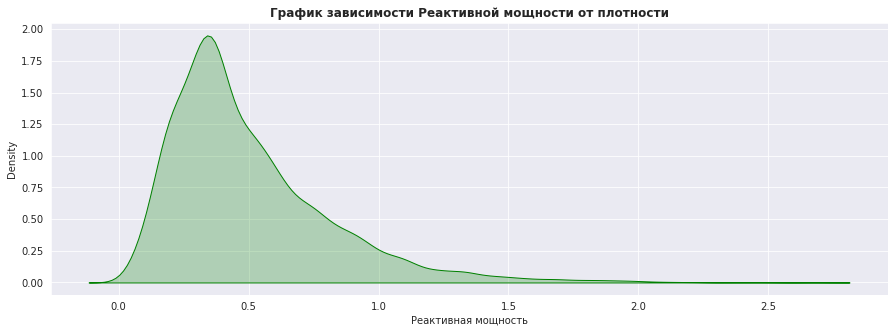

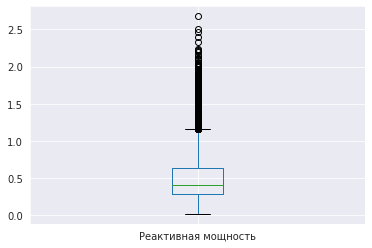

In [18]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'], color='g',legend=True,shade=True)
plt.title('График зависимости Реактивной мощности от плотности', fontweight='bold')
plt.show()
fig2 =df_arc.boxplot('Реактивная мощность')

График распредлен нормально, со сдвигом влево

Корреляция Активной и Реактивной мощности 0.9631819131519803


<Figure size 1440x720 with 0 Axes>

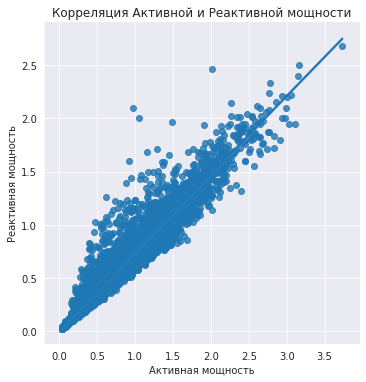

In [19]:
#Проверим корреляцию Активной и Реактивной мощности
print('Корреляция Активной и Реактивной мощности', df_arc['Активная мощность'].corr(df_arc['Реактивная мощность']))
plt.figure(figsize=(20,10))
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=df_arc)
plt.title('Корреляция Активной и Реактивной мощности')
plt.show()

Корреляция между активом и реакивом близка к единицы - модель может переобучиться, будем использовать полную мощность

In [20]:
#Расчет полной мощности
def full_power(row):
        
    full_power= math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [21]:
df_arc['Полная мощность'] = df_arc.apply(full_power, axis=1)

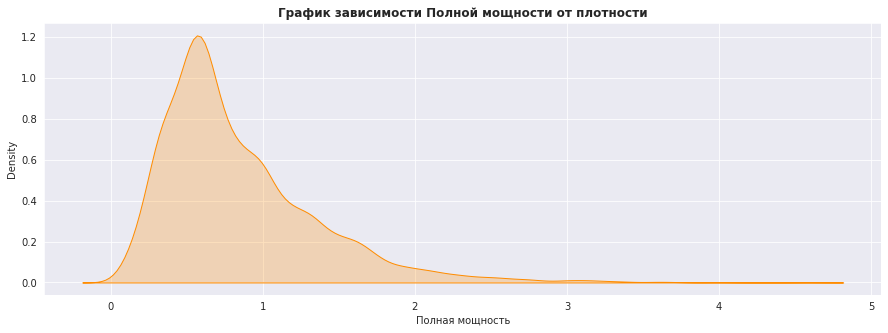

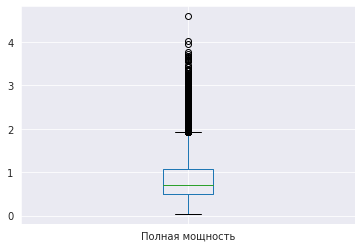

In [22]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Полная мощность'], color='darkorange',legend=True,shade=True)
plt.title('График зависимости Полной мощности от плотности', fontweight='bold')
plt.show()
fig2 =df_arc.boxplot('Полная мощность')

График распределен нормально, со сдвигом влево

<div class="alert alert-block alert-info">
    
1. Дубликатов нет, пропущенных значений нет

2. Данные приведены к нужному типу 
    
3. Были аномальные значения в реактивной мощности, от них мы избавились
    
4. Расчитали значение полной мощности для дальнейшего анализа
</div>

### Данные о подаче сыпучих материалов (объём)

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3113,3226,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,68.0,204.0,NaN,150.0,206.0
110,123,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,255.0,NaN
2404,2496,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0


-------------------------------------------------------------------------------------------------------------
**Вывод первых пяти строк датафрейма**


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


0

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
-------------------------------------------------------------------------------------------------------------


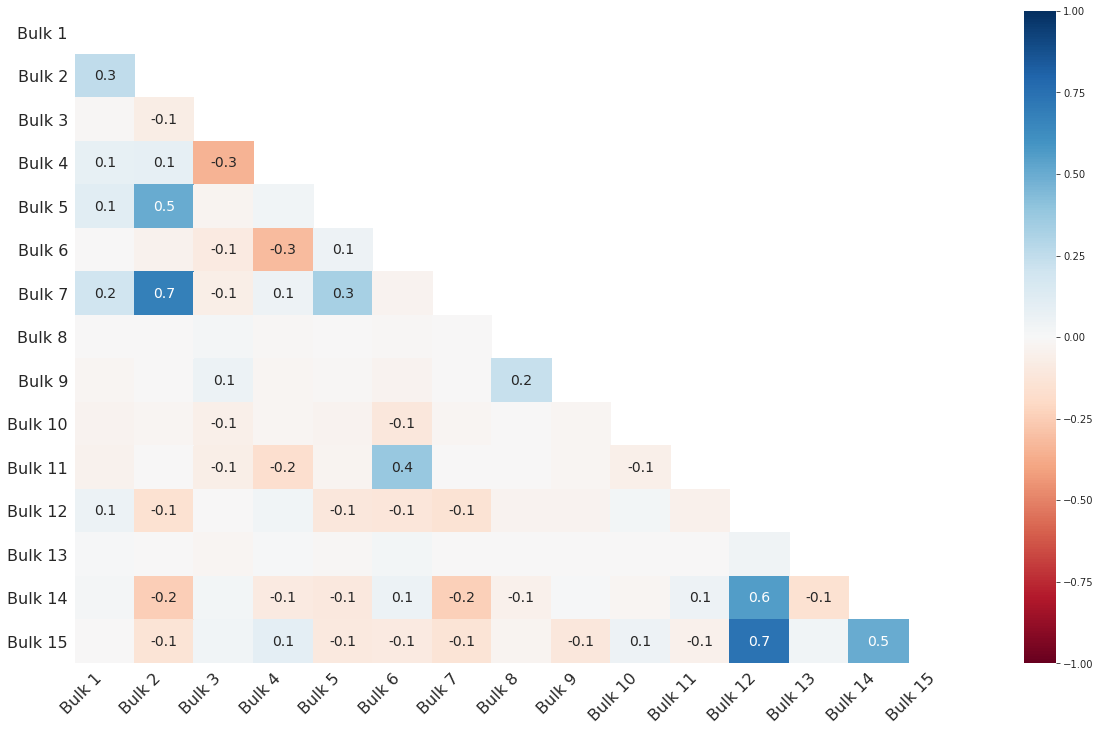

In [23]:
fun_date(df_bulk)

<div class="alert alert-block alert-info">
    
1. Типы данных в порядке, дубликатов нет
    
2. Имеются пропущенные значение, объясняется это тем, что в каждую партию добавляет определенное количество материалов
</div>

### Данные о продувке сплава газом

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**


,key,Газ 1
2161,2164,10.021713
1603,1606,11.502420
2248,2251,10.177622


-------------------------------------------------------------------------------------------------------------
**Вывод первых пяти строк датафрейма**


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


0

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


key      0
Газ 1    0
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
-------------------------------------------------------------------------------------------------------------


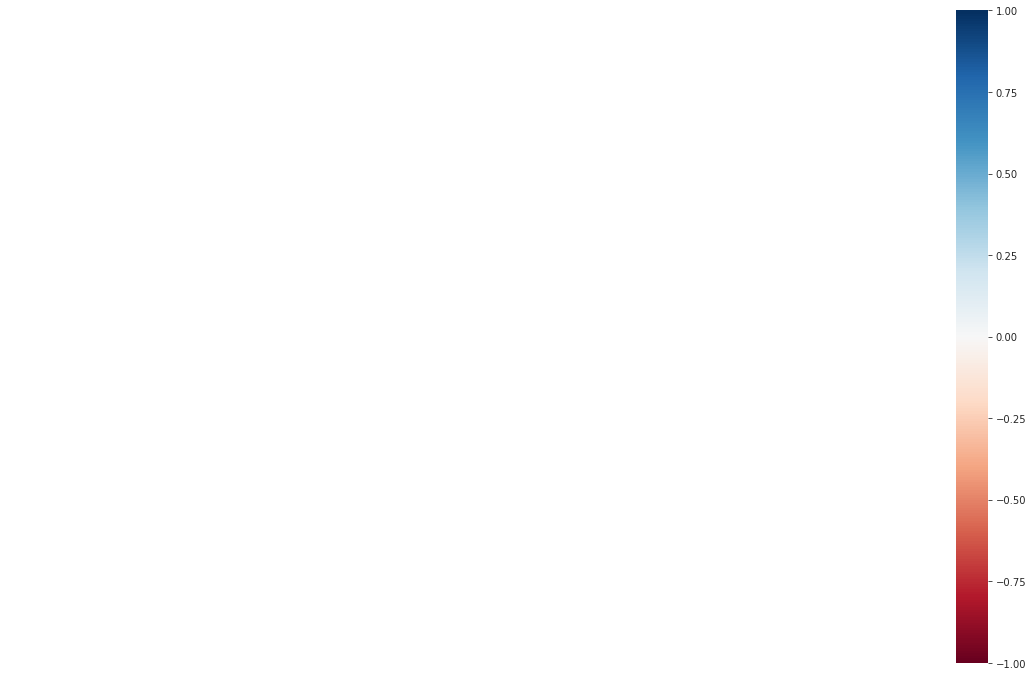

In [24]:
fun_date(df_gas)

In [25]:
#Количесво уникальных значений key
len((df_gas['key']).unique())

3239

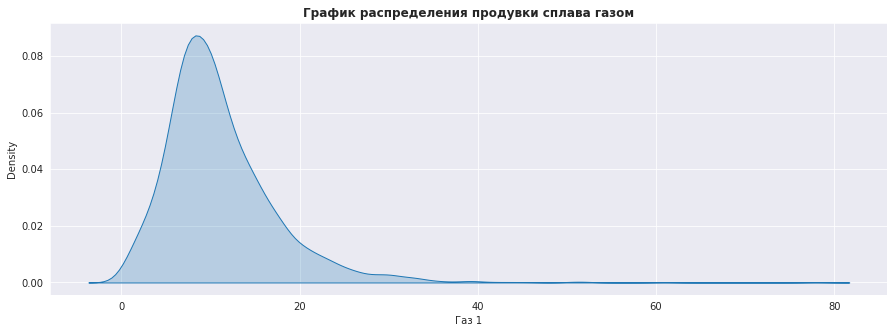

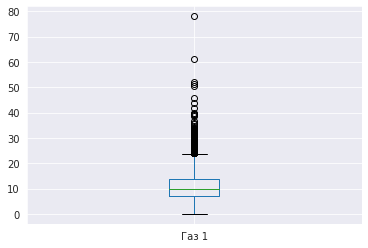

In [26]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_gas['Газ 1'], legend=True,shade=True)
plt.title('График распределения продувки сплава газом', fontweight='bold')
plt.show()
fig2 =df_gas.boxplot('Газ 1')

График распредлен нормально

<div class="alert alert-block alert-info">
    
1. Типы данных в порядке, дубликатов нет, пропущенных значений нет
    

</div>

### Результаты измерения температуры

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**


,key,Время замера,Температура
9251,1883,2019-07-09 09:52:03,1604.0
8217,1673,2019-07-02 02:30:35,1582.0
15422,3135,2019-08-28 16:50:17,NaN


-------------------------------------------------------------------------------------------------------------
**Вывод первых пяти строк датафрейма**


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


0

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


key                0
Время замера       0
Температура     2901
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
-------------------------------------------------------------------------------------------------------------


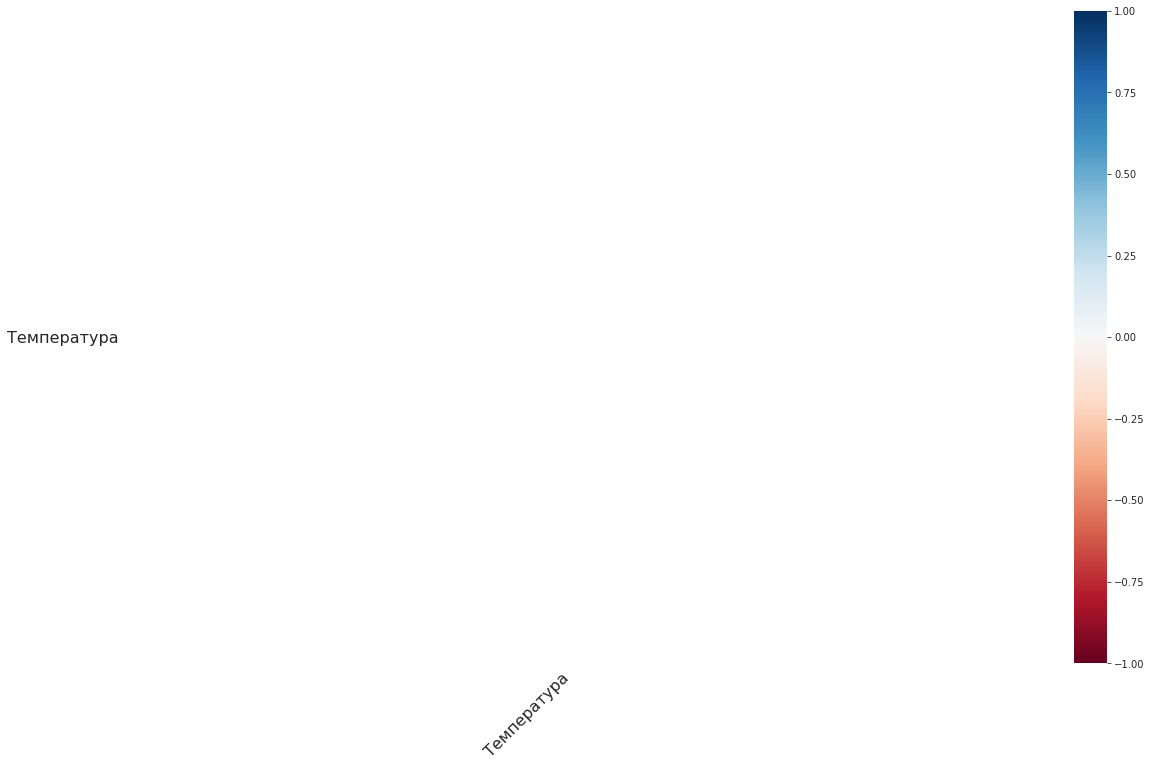

In [27]:
fun_date(df_temp)

In [28]:
#Приведем типы данных в нужный формат
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [29]:
#Удалим пропущенные значения
df_temp.dropna().reset_index(drop = True)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


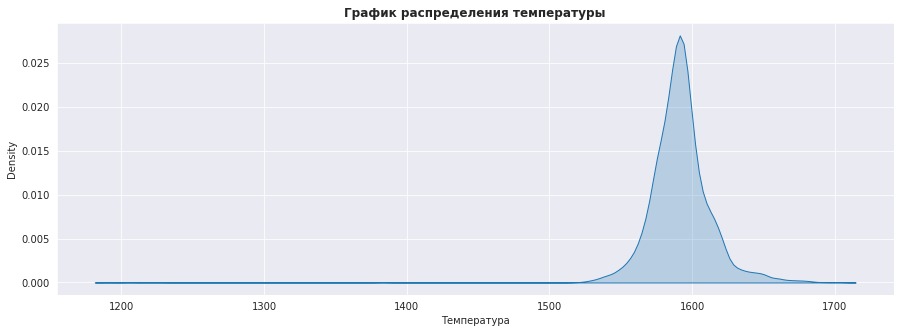

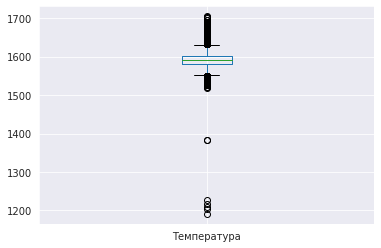

In [30]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_temp['Температура'], legend=True,shade=True)
plt.title('График распределения температуры', fontweight='bold')
plt.show()
fig2 =df_temp.boxplot('Температура')

Распределение нормальное, смещенно вправо

<div class="alert alert-block alert-info">
    
1. Типы данных приведены в нужный формат, дубликатов нет
    
2. Есть пропущенные значения, их мы удалим, потому что в нашем случае усреднить и заполнить не получится, потому что идет зависимость по времени и материалу сплава. А удаляем мы их по причине того, что данные без значения температуры не несут для нас никакой информации.
</div>

### Данные о проволочных материалах (объём)

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2642,2776,83.123039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1566,1645,103.100396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2454,2581,75.129601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------
**Вывод первых пяти строк датафрейма**


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


0

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)
-------------------------------------------------------------------------------------------------------------


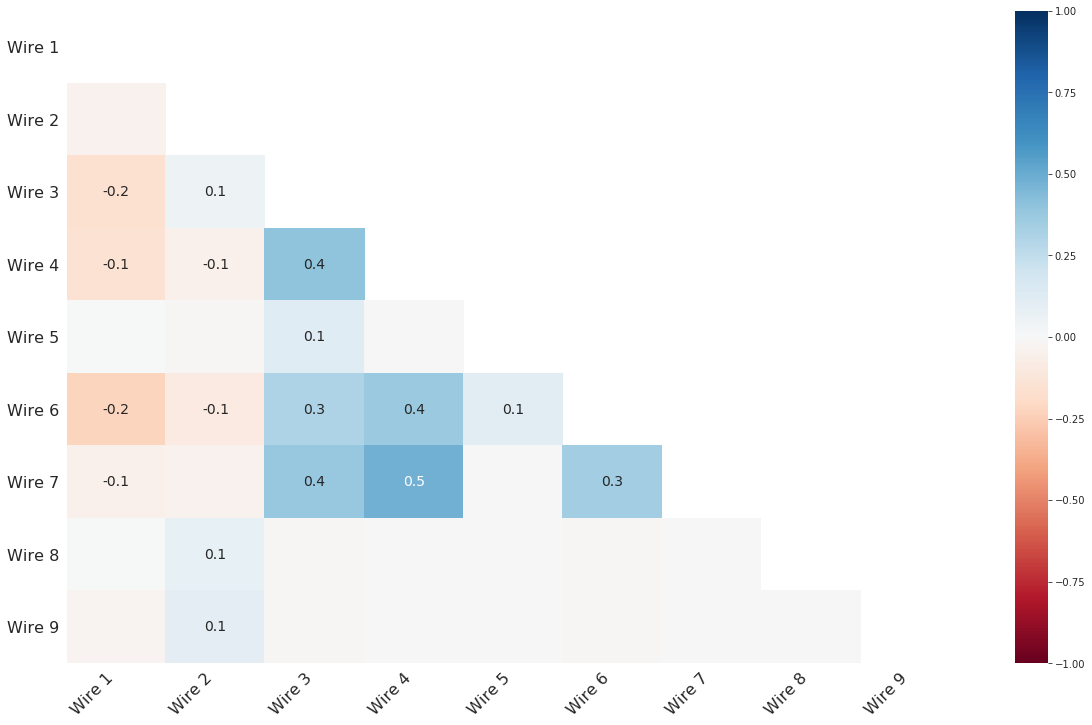

In [31]:
fun_date(df_wire)

<div class="alert alert-block alert-info">
    
1. Типы данных в правильном формате, дубликатов нет
    
2. Есть пропущенные значения, связано это с тем, что материалы добавлялись в конкретные партии.
</div>

## Исследовательский анализ

<div class="alert alert-block alert-info">
План:
    
1. Проработать таблицу df_arc для дальнейшей работы определения целевого признака
    
2. Проработать таблицу df_temp(определить начальные и конечные замеры)
    
3. Объединить все в одну таблицу
    
4. Определить целевой признак    
</div>

In [32]:
#Определим количество итераций нагрева
df_arc_count = df_arc.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
df_arc_count.columns = ['key','Количество итераций нагрева']
#df_arc_count.head(3)
#сгруппируем по партиям
df_arc = df_arc.groupby(by = 'key', as_index = False).sum()
df_arc = df_arc.merge(df_arc_count, how='left', on = 'key')

In [33]:
df_arc = df_arc.drop(columns = ['Активная мощность', 'Реактивная мощность'], axis = 1)

In [34]:
#Удалим пропуски в таблице df_temp
df_temp = df_temp.dropna(subset=['Температура']).reset_index(drop=True)
df_temp = df_temp.sort_values(by=['Время замера'])

In [35]:
#Дропнем данные, где только один замер температуры
count = df_temp.groupby(by = 'key', as_index=False).count()
one = count[count['Время замера']== 1]['key'].tolist()
df_temp = df_temp.query('key not in @one')

In [36]:
#сгруппируем по первым и последним значениям
df_temp = df_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'Время замера 1', 'Время замера 2','Температура 1','Температура 2']
df_temp = df_temp[['key','Температура 1','Температура 2']]

In [37]:
df_temp

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


In [38]:
#объединим все в одну таблицу
data = (df_temp.merge(df_arc, how='left', on = 'key').merge(df_wire, how='left', on = 'key').merge(df_bulk, how='left', on = 'key').merge(df_gas, how='left', on = 'key'))

In [39]:
data = data.fillna(0)
#data = data.drop(columns = ['key'], axis = 1)
data.rename(columns={'Температура 1': 'Temp 1', 'Температура 2': 'Temp 2','Полная мощность': 'Full_pwr', 'Количество итераций нагрева': 'Count_iter'}, inplace=True)

data

,key,Temp 1,Temp 2,Full_pwr,Count_iter,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,5.826395,5,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,3.649216,4,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,2.989534,5,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.814962,4,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4.035758,4,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.986869,4,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2471,2496,1554.0,1591.0,5.057033,6,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2472,2497,1571.0,1589.0,2.885017,3,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2473,2498,1591.0,1594.0,4.143749,5,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


### Вывод

<div class="alert alert-block alert-info">

    
1. Определили количество итераций нагрева 
    
2. Избавились от ненужных данных

3. Определили начальный и конечный замер температуры 

4. Объединили все в одну таблицу 
    
5. Определили целевой признак - конечная температура
</div>

## Обучение модели

<div class="alert alert-block alert-info">
План:
    
1. Разбить данные на таргеты и фичи
    
2. Обучить несколько моделей и выбрать наиболее эффективную, при необходимости подобрать оптимальные гиперпараметры
    
3. Провести обучение на тестовой выборке
    
4. Определить лучшую модель и сделать  её анализ    
</div>

In [40]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [41]:
train.columns

Index(['key', 'Temp 1', 'Temp 2', 'Full_pwr', 'Count_iter', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Газ 1'],
      dtype='object')

In [42]:
train_features = train.drop(['Temp 2','key'], axis =1)
train_target = train['Temp 2']

test_features = test.drop(['Temp 2','key'], axis =1)
test_target = test['Temp 2']

scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
print(len(train))
print(len(test))

1980
495


1. Разбили обучающую и тестовую выборку 70/20
2. Раскидали на таргеты и фичи, целевой признак - вторая(конечная) температура
3. Обучили скалер на тренировочной части данных, чтобы уменьшить переобучение

### Обучение на тренировачной выборке

In [43]:
result_list=[]
def hq (model):
    train_predict=model.predict(train_features)
    result_list.append({
        
        'train_mae_score': mean_absolute_error(train_target, train_predict)})    

In [44]:
model_cat=CatBoostRegressor(iterations=10,learning_rate=1,depth=5, random_seed=12345)
model_cat.fit(train_features, train_target)

0:	learn: 10.8228260	total: 48.9ms	remaining: 440ms
1:	learn: 9.8784807	total: 50.3ms	remaining: 201ms
2:	learn: 9.3523804	total: 51.5ms	remaining: 120ms
3:	learn: 9.0403004	total: 52.5ms	remaining: 78.8ms
4:	learn: 8.7598949	total: 53.5ms	remaining: 53.5ms
5:	learn: 8.5842919	total: 54.6ms	remaining: 36.4ms
6:	learn: 8.2848954	total: 55.7ms	remaining: 23.9ms
7:	learn: 8.1729926	total: 62.7ms	remaining: 15.7ms
8:	learn: 8.0693578	total: 105ms	remaining: 11.6ms
9:	learn: 7.9652169	total: 106ms	remaining: 0us


In [45]:
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
model_LGBM = lgb.LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345)
model_LGBM.fit(train_features, train_target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
hq(model_cat)
hq(model_LGBM)
hq(model_lr)

In [48]:
result1 = pd.DataFrame(result_list, columns=['train_mae_score'], index=['model_cat','model_lr','model_LGBM'])
result1

,train_mae_score
model_cat,6.015873
model_lr,4.612429
model_LGBM,7.897753


### Обучение на тестовой выборке

In [49]:
result_list2=[]
def hq1 (model):
    test_predict=model.predict(test_features)
    result_list2.append({
        
        'test_mae_score': mean_absolute_error(test_target, test_predict)})

In [50]:
model_cat=CatBoostRegressor(iterations=10,learning_rate=1,depth=5, random_seed=12345)
model_cat.fit(test_features, test_target)

0:	learn: 11.5322098	total: 1.87ms	remaining: 16.8ms
1:	learn: 9.4631182	total: 2.68ms	remaining: 10.7ms
2:	learn: 8.8770634	total: 3.41ms	remaining: 7.96ms
3:	learn: 8.5024171	total: 4.04ms	remaining: 6.06ms
4:	learn: 8.0261339	total: 4.69ms	remaining: 4.69ms
5:	learn: 7.4599081	total: 5.36ms	remaining: 3.57ms
6:	learn: 7.1374747	total: 5.98ms	remaining: 2.56ms
7:	learn: 7.0030521	total: 6.62ms	remaining: 1.65ms
8:	learn: 6.6401749	total: 7.21ms	remaining: 801us
9:	learn: 6.3176344	total: 7.87ms	remaining: 0us


In [51]:
model_lr = LinearRegression()
model_lr.fit(test_features, test_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
model_LGBM = lgb.LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345)
model_LGBM.fit(test_features, test_target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
hq1(model_cat)
hq1(model_LGBM)
hq1(model_lr)

In [54]:
result2 = pd.DataFrame(result_list2, columns=['test_mae_score'], index=['model_cat','model_lr','model_LGBM'])


In [55]:
#Выведем общий результат
result1.join(result2)

,train_mae_score,test_mae_score
model_cat,6.015873,4.908339
model_lr,4.612429,3.614600
model_LGBM,7.897753,7.636313


### Вывод

<div class="alert alert-block alert-info">
LinearRegression показывает сомнительный результат, правдоподобнее результаты у CatBoost её и будем использовать
</div>


## Анализ модели CatBoost

In [56]:
train1, test1 = train_test_split(data, test_size=0.2, random_state=42)

In [57]:
train_features1 = train1.drop(['Temp 2','key'], axis =1)
train_target1 = train1['Temp 2']

test_features1 = test1.drop(['Temp 2','key'], axis =1)
test_target1 = test1['Temp 2']

In [58]:
model_cat1=CatBoostRegressor(iterations=10,learning_rate=1,depth=5, random_seed=12345)
model_cat1.fit(test_features1, test_target1)

0:	learn: 11.5322098	total: 944us	remaining: 8.5ms
1:	learn: 9.4631182	total: 1.52ms	remaining: 6.08ms
2:	learn: 8.8636133	total: 2.2ms	remaining: 5.14ms
3:	learn: 8.4877106	total: 2.87ms	remaining: 4.3ms
4:	learn: 8.2368277	total: 3.5ms	remaining: 3.5ms
5:	learn: 7.5842282	total: 4.14ms	remaining: 2.76ms
6:	learn: 7.2452775	total: 4.76ms	remaining: 2.04ms
7:	learn: 6.9129794	total: 5.49ms	remaining: 1.37ms
8:	learn: 6.4748291	total: 6.12ms	remaining: 680us
9:	learn: 6.2124538	total: 6.76ms	remaining: 0us


In [59]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=test_features1.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

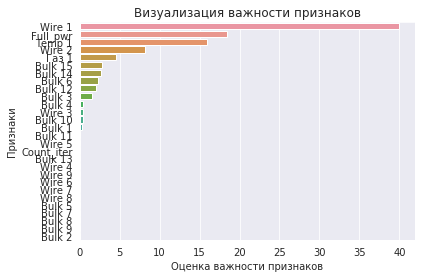

In [60]:
chart_feature_imp(model_cat)

In [61]:
test_predict=model_cat.predict(test_features)
mae = mean_absolute_error(test_target, test_predict)
print('MAE на тестовой выборке=',mae)

MAE на тестовой выборке= 4.908338946875535


###  Вывод

<div class="alert alert-block alert-info">

Мы провели финальное тестирование нашей модели. Модель показала результат МАЕ 4.9 на тестовой выборке, что соответсвует условию решения задачи. Также эта модель предсказывает лучше, чем модель со средними значениями. 
</div>

## Общий вывод

<div class="alert alert-block alert-info">

    
1. Мы провели Исследовательский анализ
    
2. Обработали пропуски и выбросы

3. Добавили несколько новых признаков для нашей модели 

4. Для очучения использовали 3 модели: CatBoost,LGBMRegressor,LinearRegression
    
5. Лучше всего себя показала модель CatBoost с МАЕ 4.9 
</div>

# Отчет о проделанной работе

**1. Все пункты плана были выполнены в полном объеме. За исключением выгрузки всех представленных датасетов. В последствии работы выяснилось, что датасеты bulk_time и wire_time не играют никакой роли для достижения поставленной задачи.**

**2. Основная трудность возникла в понимании физического процесса работы. Поскольку нужно понимать, какие данные проверять на мультиколлинеарность.**

**Также трудности возникли в работе сразу с несколькими моделями, поскольку некоторые отказываются работать без масштабирования, что в свою очередь, снижает переобучение. В следствии чего приходится делать ставку на конкретную модель, которая выдает более стабильный и уверенный результат и далее работать с ней отдельно от всех.**

**3. Ключевые шаги - это, естесвенно, предобработка данных, без нее никуда. После чего, это все перетекает в исследовательский анализ, из которого уже можно понять, какие целевые признаки мы выделяем, чтобы в дальнейшем обучить нашу модель.**

**4. Итоговой моделью стал CatBoost, который дает стабильный результат и удовлетворяет условию задачи.**

Посмотрев на графики, сделанные в Предобработке данных(3), можно сделать несколько выводов. Во-первых большинство переменных у нас фактически количесвенные. Во-вторых, это условно-непрерывные переменные. В-третьих, выбросов практически нет, но даже если они и были - мы от них избавились. 

Зачастую, при проведении анализа, некоторые переменные оказываются ненужными. Это означает, что если выкинуть их из анализа, то при решении нашей задачи, мы даже в худшем случае почти ничего не потеряем. Чтобы подтвердить эту гипотезу, мы использовали метод feature_importances_, который показывает какие фичи, оказывают сильное влияние на точность модели. Конкретно в моем случае лишние, фичи можно не дропать(хоть это  и вляется шумом для модели). 

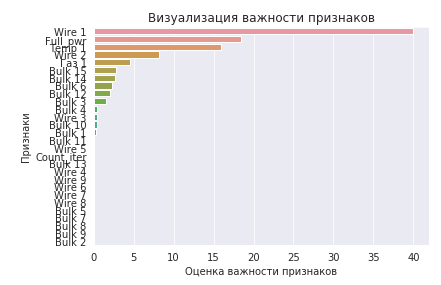






Потому чтобы была проведена хорошая предобработка таргетов и фичей, благодаря чему, выбранная нами модель(CatBoost) обошлась базовыми гиперпараметрами - Количество итераций=10,Скорость процессинга=1,Глубина=5, Генератор случайных чисел=12345. 
В следствии чего был получен хороший результат МАЕ на тренировочной и тестовой выборках.

MAE на тренировочной выборке= 6.015873

MAE на тестовой выборке= 4.90833